In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

In [18]:
world_size = 20
world =\
"""wwwwwwwwwwwwwwwwwwww
w          bb      w
wbbb w  o       o  w
w    w       e     w
w owwwwwwwwwwwwww  w
wb w  o  b       b w
w  w  w  w     w b w
w bw  w  wbbwwww b w
w     w  w     w b w
w     w  w     w   w
wwwww w  ww    w  ow
w     w   w  w www w
w  wwwww  wbbw   w w
w      w  w  w   w w
wbb    w  w  w     w
w   s  w  o  wwwwbbw
w      b  o        w
www    wwwwww o  o w
w      o           w
wwwwwwwwwwwwwwwwwwww"""

# Action Space
A = ['U', 'D', 'L', 'R']

In [19]:
# world_size = 7
# world =\
# """wwwwwww
# ww    ww
# ww wb ww
# ww w bww
# ww wweww
# wwbs www
# wwwwwwww"""

In [20]:
# Dana Research Center 309
w = world.split('\n')
gridworld_char = []
for i in range(len(w)):
    gridworld_char.append(list(w[i]))

# PLOT FUNCTION
def plot_map(gridworld_char, S_space, V_map, plot_type):
    # Wall map
    gridworld_int = np.zeros((world_size,world_size))
    for i in range(world_size):
        for j in range(world_size):
            if gridworld_char[i][j] == 'w':
                gridworld_int[i][j] = np.NAN
            else:
                gridworld_int[i][j] = 0

    # Annotate numbers
    ANNOT = None
    if plot_type == 'V_map':
        ANNOT = V_map

    # Plot Heatmap
    plt.subplots(figsize=(10,7.5))  
    heatmap = sns.heatmap(gridworld_int, fmt=".0f", annot=ANNOT, linewidths=0.25, linecolor='black',
                        cbar= False, cmap= 'rocket_r')
    heatmap.set_facecolor('black')

    # state blocks
    for x in range(world_size):
        for y in range(world_size):
            if gridworld_char[x][y] == 'o': # Oil
                rect = Rectangle((y, x), 1, 1, fill=True, color='red', alpha = 0.8)
                heatmap.add_patch(rect)
            if gridworld_char[x][y] == 'b': # Bump
                rect = Rectangle((y, x), 1, 1, fill=True, color='red', alpha = 0.25)
                heatmap.add_patch(rect)
            if gridworld_char[x][y] == 's': # Start
                rect = Rectangle((y, x), 1, 1, fill=True, color='blue', alpha = 0.8)
                heatmap.add_patch(rect)
            if gridworld_char[x][y] == 'e': # End
                rect = Rectangle((y, x), 1, 1, fill=True, color='green', alpha = 0.8)
                heatmap.add_patch(rect)

    # Arrows
    if plot_type != "V_map":

        if plot_type == 'arrow':
            arrow_space = S_space
        elif plot_type == 'path':
            arrow_space = get_path(S_space)

        for state in arrow_space:
            if state.s_content == 'e':
                continue
            r = state.row # x_coordinate
            c = state.col # y_coordinate
            if state.policy == 'R':
                plt.arrow(c + 0.5, r + 0.5, 0.8, 0, width=0.04, color='black')   # Right
            if state.policy == 'L':
                plt.arrow(c + 0.5, r + 0.5, -0.8, 0, width=0.04, color='black')  # Left
            if state.policy == 'U':
                plt.arrow(c + 0.5, r + 0.5, 0, -0.8, width=0.04, color='black')  # Up
            if state.policy == 'D':
                plt.arrow(c + 0.5, r + 0.5, 0, 0.8, width=0.04, color='black')  # Down
    plt.show()


def get_path(S_space):
    # get start end index
    for s in S_space:
        if s.s_content == 's':
            start_index = S_space.index(s)
        if s.s_content == 'e':
            terminal_index = S_space.index(s)
    path = []

    # Loop from start to end
    curr_state = S_space[start_index]
    count = 0
    while curr_state != S_space[terminal_index]:
        path.append(curr_state)
        action = curr_state.policy
        next_state_index = curr_state.s_next_index[A.index(action)]
        curr_state = S_space[next_state_index]

        count = count+1
        if count>len(S_space):
            return path
    return path

V_map = np.zeros((world_size,world_size))


In [21]:

# Transition Probabilities p(s'|s,a)
def Prob(p, next, action):
    
    # find next_state after acting on state
    if next == action:
        return 1-p
    else:
        return p/3


# Reward r(s, a, s')
def Reward(state, action, next_state):
    next_state_content = next_state.s_content

    reward = -1    
    # rewards
    if next_state_content=='b':
        reward = reward -10
    if next_state_content=='o':
        reward = reward -5
    if next_state_content=='e':
        reward = reward +200

    if state.s_content == 'e':
        reward = 0
    return reward

In [22]:
class State:
    def __init__(self, row, col, s_content, s_next_content):
        # state location
        self.row = row
        self.col = col
        # 
        self.action = ['U','D','L','R']         # UDLR
        self.s_next_content = s_next_content    # w/b/o/''
        self.s_next_index = []                  # U: 0, D: 0, L:0, R:0
        self.s_content = s_content              
        #
        self.index = -1
        self.value = 0
        self.policy = 'D'

    # next state num --> UDLR
    def get_action(self, state_index):
        i = self.s_next_index.index(state_index)
        return self.action[i]


# initialize State Space
S_space = []
for row in range(world_size):
    for col in range(world_size):
        if gridworld_char[row][col] != 'w':
            # available actions
            s_next_content = {}

            s_next_content.update( {'U':gridworld_char[row-1][col]})
            s_next_content.update( {'D':gridworld_char[row+1][col]})
            s_next_content.update( {'L':gridworld_char[row][col-1]})
            s_next_content.update( {'R':gridworld_char[row][col+1]})       

            S_space.append(State(row, col, gridworld_char[row][col], s_next_content))


terminal_index = 0
start_index = 0
i = 0 


for state in S_space:

    # start
    if state.s_content == 's':
        start_index = S_space.index(state)
    # goal
    if state.s_content == 'e':
        terminal_index = S_space.index(state)

    # index
    state.index = i
    i = i+1

    # neighbor states
    row = state.row
    col = state.col
    coordinates = [[row-1, col],    #up
                   [row+1, col],    #down
                   [row, col-1],    #left
                   [row, col+1]]    #right
    
    for coord in coordinates:
        is_state = False
        next_state = 0
        # search for UDLR states
        for s in S_space:
            if coord[0]==s.row and coord[1]==s.col:
                next_state = s
                is_state = True
        # if found, add next state
        if is_state:
            state.s_next_index.append(S_space.index(next_state))
        # if not found, go back to curr state
        else:
            state.s_next_index.append(S_space.index(state))
            
i = terminal_index
state = S_space[i]

# print(state.action)
# print(state.row, state.col,)
# print(state.s_next_index)
# print(len(S_space))

# r_vector = []
# for j in range(4):
#     next_state = S_space[state.s_next_index[j]]
#     r_vector.append(Reward(state,'U',next_state))

# print(r_vector)

In [23]:
# Policy Iteration

def PI(S_space, p, discount, theta):
    iteration = 0
    policy_stable = False
    while not policy_stable:
        iteration = iteration +1
        stable_list = []
        delta = 999

        #---------- Policy Evaluation ---------#
        while delta > theta:
            for s in S_space:
                v_old = s.value
                v_new = 0

                # policy
                action = s.policy

                # Sum of next state (UDLR)
                for next in s.action:
                    i = s.s_next_index[A.index(next)]    # index of next state
                    next_state = S_space[i]

                    # value calc
                    v_new = v_new + Prob(p, next, action) * \
                            ( Reward(s, action, next_state) + discount* next_state.value)

                # Goal always 0
                if S_space.index(s) == terminal_index: 
                    v_new = 0

                # update value
                s.value = v_new

                # update delta
                delta = np.abs(v_old - v_new)



        #---------- Policy Improvement ---------#
        for s in S_space:
            old_action = s.policy
            V_vector = []

            # actions
            for action in s.action:
                v_new = 0
                # Sum of s'
                for next in s.action:
                    i = s.s_next_index[A.index(next)]    # index of next state
                    next_state = S_space[i]

                    # value calc
                    v_new = v_new + Prob(p, next, action) * \
                            ( Reward(s, action, next_state) + discount* next_state.value)

                V_vector.append(v_new)

            # argmax (Action with max V)
            V_vector = np.array(V_vector)
            new_action = A[np.argmax(V_vector)]

            # improve policy
            s.policy = new_action
        
            # check stable
            if old_action == new_action:
                stable_list.append(True)
            else:
                stable_list.append(False)
            
        # check if all stable
        policy_stable = True
        for i in stable_list:
            if i == False:
                policy_stable = False


    #---------- Plot ---------#
    V_map = np.zeros((world_size,world_size))
    for s in S_space:
            V_map[s.row][s.col] = s.value

    print("Number of iterations = ", iteration)
    plot_map(gridworld_char, S_space, V_map, 'V_map')
    plot_map(gridworld_char, S_space, V_map, 'arrow')
    plot_map(gridworld_char, S_space, V_map, 'path')
    return


Number of iterations =  12


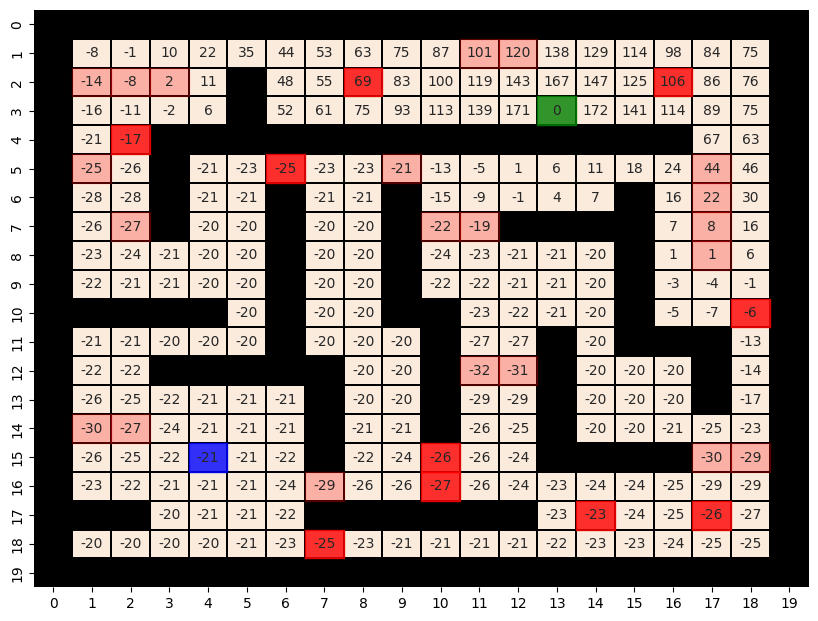

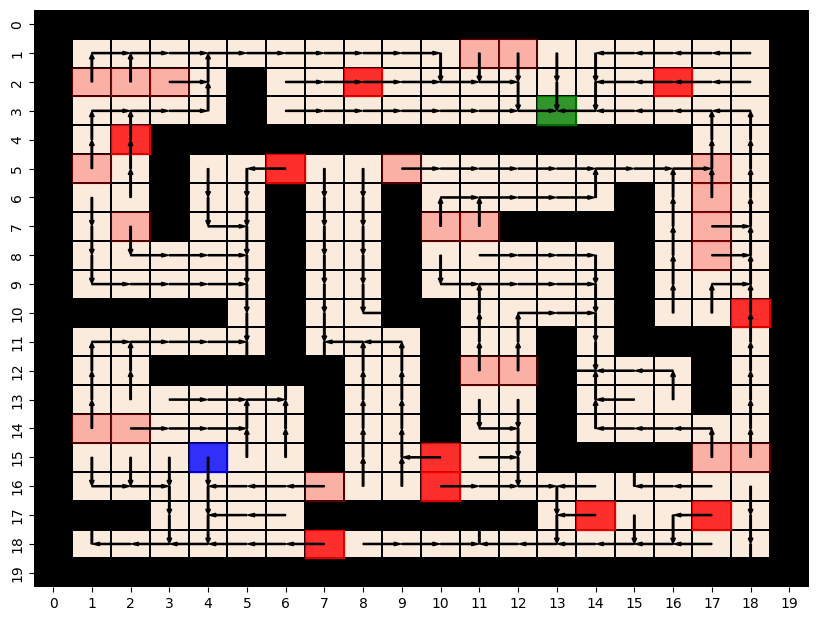

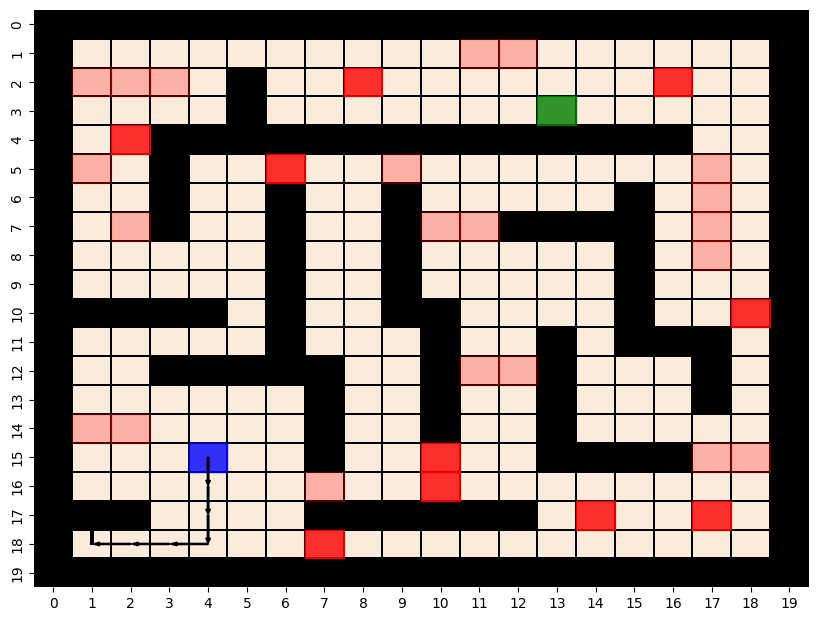

In [24]:
# PI(S_space, p=0, discount=0.9, theta=0.8)  # Deterministic

# PI(S_space, p=0.02, discount=0.95, theta=0.01)  # Base

PI(S_space, p=0.5, discount=0.95, theta=0.01)   # Large Stochastic

# PI(S_space, p=0.02, discount=0.55, theta=0.01)  # Small Discount Factor